## ASSIGNMENT 3
### Akshay Santoshi - CS21BTECH11012

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
from torchvision.utils import make_grid
from torchvision.models import inception_v3, Inception_V3_Weights
import torch.nn.functional as F
from denoising_diffusion_pytorch import Unet, GaussianDiffusion
import os
from pytorch_fid import fid_score
from torchvision import datasets, transforms
import seaborn as sns
from sklearn.manifold import TSNE

In [4]:
def compute_normalized_histogram(image_path, bins=256):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    hist, bin_edges = np.histogram(image, bins=bins, range=(0,256))
    hist = hist.astype(np.float32)/hist.sum()
    return hist, bin_edges

In [5]:
left_hist, left_bins = compute_normalized_histogram('left.png')
right_hist, right_bins = compute_normalized_histogram('right.png')

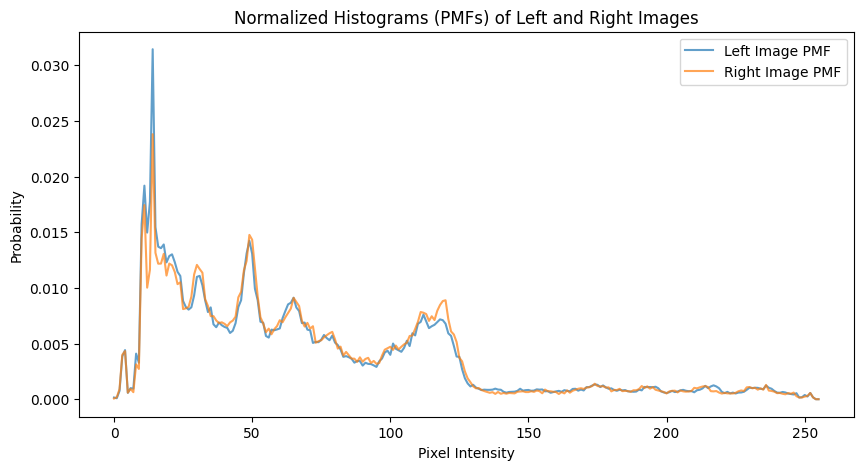

In [6]:
plt.figure(figsize=(10,5))
plt.plot(left_bins[:-1], left_hist, label ="Left Image PMF", alpha=0.7)
plt.plot(right_bins[:-1], right_hist, label ="Right Image PMF", alpha=0.7)
plt.xlabel("Pixel Intensity")
plt.ylabel("Probability")
plt.legend()
plt.title("Normalized Histograms (PMFs) of Left and Right Images")
plt.show()

### Question 1(a)

In [7]:
def kl_divergence(p, q, epsilon=1e-10):
    p = np.clip(p, epsilon, 1.0)
    q = np.clip(q, epsilon, 1.0)
    
    p = p / p.sum()
    q = q / q.sum()
    kl = np.sum(p * np.log(p/q))
    return kl

In [8]:
kl_pq = kl_divergence(left_hist, right_hist)
kl_qp = kl_divergence(right_hist, left_hist)

print(f"KL(p || q) = {kl_pq:.4f}")
print(f"KL(q || p) = {kl_qp:.4f}")
print(f"Difference (KL(p || q) - KL(q || p)) = {kl_pq - kl_qp:.4f}")
print(f"Are they equal? {np.isclose(kl_pq, kl_qp)}")

KL(p || q) = 0.0105
KL(q || p) = 0.0100
Difference (KL(p || q) - KL(q || p)) = 0.0005
Are they equal? False


This verifies that the KL divergence is not symmetric.

### Question 1(b)

In [9]:
def js_divergence(p, q):
    m = (p+q)/2
    kl_pm = kl_divergence(p, m)
    kl_qm = kl_divergence(q, m)
    js = 0.5*(kl_pm + kl_qm)
    return js

In [10]:
js_pq = js_divergence(left_hist, right_hist)
js_qp = js_divergence(right_hist, left_hist)

print("JS Divergence:")
print(f"JS(p, q) = {js_pq:.4f}")
print(f"JS(q, p) = {js_qp:.4f}")
print(f"Difference (JS(p, q) - JS(q, p)) = {js_pq - js_qp:.8f}")
print(f"Are they equal? {np.isclose(js_pq, js_qp)}")

print("\nKL Divergence")
print(f"KL(p || q) = {kl_pq:.4f}")
print(f"KL(q || p) = {kl_qp:.4f}")
print(f"Difference (KL(p || q) - KL(q || p)) = {kl_pq - kl_qp:.4f}")
print(f"Are they equal? {np.isclose(kl_pq, kl_qp)}")

JS Divergence:
JS(p, q) = 0.0025
JS(q, p) = 0.0025
Difference (JS(p, q) - JS(q, p)) = 0.00000000
Are they equal? True

KL Divergence
KL(p || q) = 0.0105
KL(q || p) = 0.0100
Difference (KL(p || q) - KL(q || p)) = 0.0005
Are they equal? False


This verifies that the JS( p, q) is symmetric indeed while D ( p||q) is not.

### Question 1(c)

In [11]:
rX = left_hist
sY = right_hist

In [12]:
def create_valid_joint_histogram(rX, sY):
    return np.outer(rX, sY)

In [13]:
# Create a valid joint histogram
pXY_valid = create_valid_joint_histogram(rX, sY)

In [14]:
def create_invalid_joint_histogram(pXY_valid):
    pXY_invalid = pXY_valid.copy()
    pXY_invalid[0, 0] += 0.05
    pXY_invalid /= pXY_invalid.sum()
    return pXY_invalid

In [15]:
# Create an invalid joint histogram
pXY_invalid = create_invalid_joint_histogram(pXY_valid)

In [16]:
def check_valid_transport_plan(pXY, rX, sY, tol=1e-6):
    row_sums = np.sum(pXY, axis=1)
    col_sums = np.sum(pXY, axis=0)

    valid_rows = np.allclose(row_sums, rX, atol=tol)
    valid_cols = np.allclose(col_sums, sY, atol=tol)
    return valid_rows and valid_cols

In [17]:
print("Verification for positive sample gives (Valid transport plan):", check_valid_transport_plan(pXY_valid, rX, sY))  
print("Verification for negative sample gives (Invalid transport plan):", check_valid_transport_plan(pXY_invalid, rX, sY))  

Verification for positive sample gives (Valid transport plan): True
Verification for negative sample gives (Invalid transport plan): False


This verifies whether $p_{(X, Y)} \in \Pi(r, s)$.

### Question 2(a)

In [18]:
# Hyperparameters
batch_size = 128
image_size = 28
latent_dim = 100  

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [19]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128 * 7 * 7),  
            nn.BatchNorm1d(128 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (128, 7, 7)),  

            # Upsample to 14x14
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            # Upsample to 28x28
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  
        )

    def forward(self, z):
        return self.model(z)

In [20]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()  
        )

    def forward(self, img):
        return self.model(img)

In [21]:
# Initialize models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss function and optimizers
criterion = nn.BCELoss()  
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

num_epochs = 50
fixed_noise = torch.randn(16, latent_dim, device=device)  

Epoch [1/50] | D Loss: 0.4994 | G Loss: 1.9886
Epoch [2/50] | D Loss: 0.1894 | G Loss: 3.6692
Epoch [3/50] | D Loss: 0.1513 | G Loss: 3.4041
Epoch [4/50] | D Loss: 0.4452 | G Loss: 1.2229
Epoch [5/50] | D Loss: 0.3051 | G Loss: 1.5943
Epoch [6/50] | D Loss: 0.2996 | G Loss: 1.7678
Epoch [7/50] | D Loss: 0.2908 | G Loss: 2.7261
Epoch [8/50] | D Loss: 0.2744 | G Loss: 2.5390
Epoch [9/50] | D Loss: 0.3829 | G Loss: 1.5730
Epoch [10/50] | D Loss: 0.4784 | G Loss: 1.5422


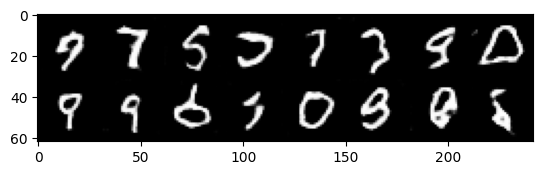

Epoch [11/50] | D Loss: 0.3442 | G Loss: 4.8599
Epoch [12/50] | D Loss: 0.5251 | G Loss: 1.4530
Epoch [13/50] | D Loss: 0.5136 | G Loss: 3.4373
Epoch [14/50] | D Loss: 0.2505 | G Loss: 2.9156
Epoch [15/50] | D Loss: 0.2771 | G Loss: 3.1651
Epoch [16/50] | D Loss: 0.2428 | G Loss: 2.9285
Epoch [17/50] | D Loss: 0.3128 | G Loss: 3.8262
Epoch [18/50] | D Loss: 0.2398 | G Loss: 2.6552
Epoch [19/50] | D Loss: 0.2024 | G Loss: 2.9605
Epoch [20/50] | D Loss: 0.1934 | G Loss: 3.0975


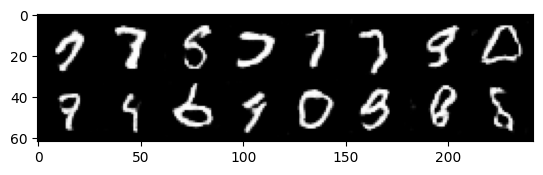

Epoch [21/50] | D Loss: 0.2004 | G Loss: 2.8503
Epoch [22/50] | D Loss: 0.2272 | G Loss: 2.8861
Epoch [23/50] | D Loss: 0.2956 | G Loss: 3.0016
Epoch [24/50] | D Loss: 0.3629 | G Loss: 2.6653
Epoch [25/50] | D Loss: 0.2412 | G Loss: 4.5018
Epoch [26/50] | D Loss: 0.3489 | G Loss: 2.4417
Epoch [27/50] | D Loss: 0.2232 | G Loss: 3.2182
Epoch [28/50] | D Loss: 0.1758 | G Loss: 2.7201
Epoch [29/50] | D Loss: 0.2096 | G Loss: 3.6817
Epoch [30/50] | D Loss: 0.1950 | G Loss: 3.8450


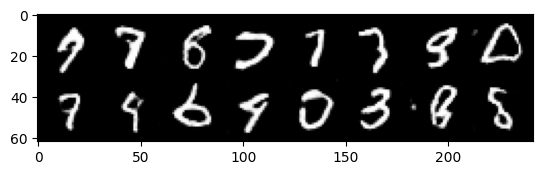

Epoch [31/50] | D Loss: 0.1970 | G Loss: 4.1392
Epoch [32/50] | D Loss: 0.4196 | G Loss: 2.0500
Epoch [33/50] | D Loss: 0.3119 | G Loss: 3.9971
Epoch [34/50] | D Loss: 0.2197 | G Loss: 4.2435
Epoch [35/50] | D Loss: 0.5380 | G Loss: 1.1187
Epoch [36/50] | D Loss: 0.1735 | G Loss: 3.0164
Epoch [37/50] | D Loss: 0.3053 | G Loss: 2.8189
Epoch [38/50] | D Loss: 0.2568 | G Loss: 2.2946
Epoch [39/50] | D Loss: 0.2100 | G Loss: 3.4762
Epoch [40/50] | D Loss: 0.2044 | G Loss: 3.5987


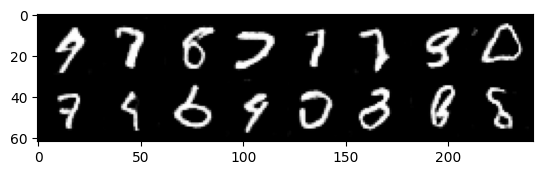

Epoch [41/50] | D Loss: 0.2128 | G Loss: 2.9470
Epoch [42/50] | D Loss: 0.3453 | G Loss: 2.3801
Epoch [43/50] | D Loss: 0.4042 | G Loss: 1.2809
Epoch [44/50] | D Loss: 0.3208 | G Loss: 2.2337
Epoch [45/50] | D Loss: 0.2016 | G Loss: 3.3982
Epoch [46/50] | D Loss: 1.7240 | G Loss: 0.4303
Epoch [47/50] | D Loss: 0.2011 | G Loss: 3.5906
Epoch [48/50] | D Loss: 0.4013 | G Loss: 3.2368
Epoch [49/50] | D Loss: 0.4540 | G Loss: 1.0973
Epoch [50/50] | D Loss: 0.2032 | G Loss: 3.7144


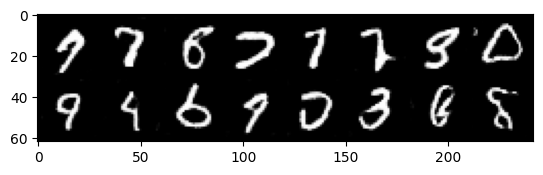

In [22]:
for epoch in range(num_epochs):
    for i, (real_imgs, _) in enumerate(train_loader):
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        optimizer_D.zero_grad()

        real_outputs = discriminator(real_imgs)
        loss_real = criterion(real_outputs, real_labels)

        z = torch.randn(batch_size, latent_dim, device=device)
        fake_imgs = generator(z).detach()  

        fake_outputs = discriminator(fake_imgs)
        loss_fake = criterion(fake_outputs, fake_labels)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()

        z = torch.randn(batch_size, latent_dim, device=device)
        fake_imgs = generator(z)

        fake_outputs = discriminator(fake_imgs)
        loss_G = criterion(fake_outputs, real_labels)  

        loss_G.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] | D Loss: {loss_D.item():.4f} | G Loss: {loss_G.item():.4f}")

    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            generated_imgs = generator(fixed_noise).cpu()
        grid = make_grid(generated_imgs, normalize=True)
        plt.imshow(grid.permute(1, 2, 0))
        plt.show()


### Question 2(b)


Training GAN with Discriminator:Generator = 1:1
Epoch [1/10] | D Loss: 0.2079 | G Loss: 2.4674
Epoch [2/10] | D Loss: 0.1662 | G Loss: 3.4255
Epoch [3/10] | D Loss: 0.1662 | G Loss: 3.7427
Epoch [4/10] | D Loss: 0.3078 | G Loss: 3.6448
Epoch [5/10] | D Loss: 0.2263 | G Loss: 2.7802


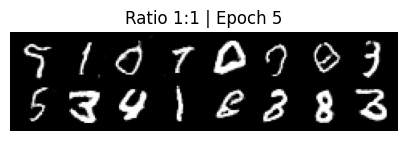

Epoch [6/10] | D Loss: 0.1887 | G Loss: 4.4872
Epoch [7/10] | D Loss: 0.2673 | G Loss: 1.5105
Epoch [8/10] | D Loss: 0.1893 | G Loss: 2.5726
Epoch [9/10] | D Loss: 0.1753 | G Loss: 4.2838
Epoch [10/10] | D Loss: 0.2567 | G Loss: 3.7869


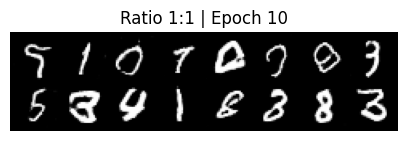


Training GAN with Discriminator:Generator = 3:1
Epoch [1/10] | D Loss: 0.4470 | G Loss: 3.9925
Epoch [2/10] | D Loss: 0.1414 | G Loss: 4.5022
Epoch [3/10] | D Loss: 0.1056 | G Loss: 4.7601
Epoch [4/10] | D Loss: 0.1034 | G Loss: 4.5543
Epoch [5/10] | D Loss: 0.0930 | G Loss: 4.8848


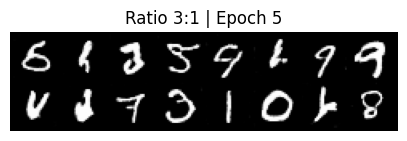

Epoch [6/10] | D Loss: 0.1549 | G Loss: 5.8309
Epoch [7/10] | D Loss: 5.7870 | G Loss: 0.0871
Epoch [8/10] | D Loss: 0.5047 | G Loss: 3.1432
Epoch [9/10] | D Loss: 0.1490 | G Loss: 5.1315
Epoch [10/10] | D Loss: 0.0444 | G Loss: 3.8937


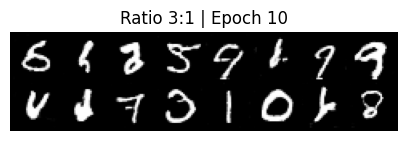


Training GAN with Discriminator:Generator = 5:1
Epoch [1/10] | D Loss: 0.1155 | G Loss: 4.9796
Epoch [2/10] | D Loss: 0.0357 | G Loss: 5.4668
Epoch [3/10] | D Loss: 0.0528 | G Loss: 4.8853
Epoch [4/10] | D Loss: 0.0872 | G Loss: 4.6488
Epoch [5/10] | D Loss: 0.1059 | G Loss: 4.6744


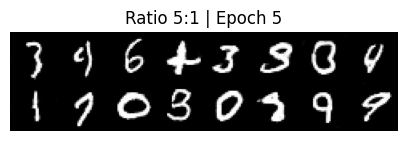

Epoch [6/10] | D Loss: 0.0457 | G Loss: 5.6864
Epoch [7/10] | D Loss: 0.0375 | G Loss: 5.2363
Epoch [8/10] | D Loss: 0.0368 | G Loss: 7.1002
Epoch [9/10] | D Loss: 0.0536 | G Loss: 5.1296
Epoch [10/10] | D Loss: 0.0422 | G Loss: 4.9669


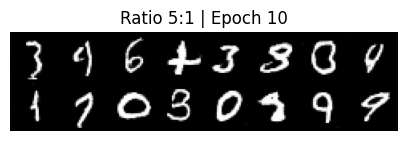


Training GAN with Discriminator:Generator = 1:5
Epoch [1/10] | D Loss: 0.1387 | G Loss: 3.6905
Epoch [2/10] | D Loss: 0.0913 | G Loss: 4.6149
Epoch [3/10] | D Loss: 0.2072 | G Loss: 5.0288
Epoch [4/10] | D Loss: 0.1667 | G Loss: 3.4475
Epoch [5/10] | D Loss: 0.2037 | G Loss: 2.9180


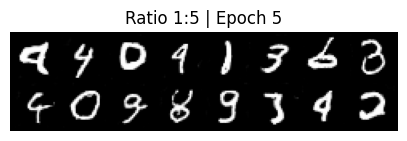

Epoch [6/10] | D Loss: 0.2480 | G Loss: 3.0544
Epoch [7/10] | D Loss: 0.2116 | G Loss: 3.4358
Epoch [8/10] | D Loss: 0.3004 | G Loss: 2.3978
Epoch [9/10] | D Loss: 0.4871 | G Loss: 2.7834
Epoch [10/10] | D Loss: 0.3614 | G Loss: 2.8559


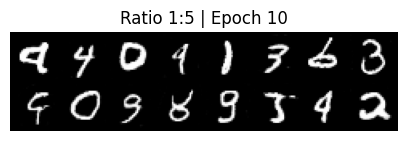

In [23]:
def train_dcgan(d_steps, g_steps, num_epochs=10):
    print(f"\nTraining GAN with Discriminator:Generator = {d_steps}:{g_steps}")

    fixed_noise = torch.randn(16, 100, device=device)  

    for epoch in range(num_epochs):
        for real_imgs, _ in train_loader:
            real_imgs = real_imgs.to(device)
            batch_size = real_imgs.size(0)

            real_labels = torch.ones(batch_size, 1, device=device)
            fake_labels = torch.zeros(batch_size, 1, device=device)

            # === Train Discriminator multiple times ===
            for _ in range(d_steps):
                optimizer_D.zero_grad()

                real_outputs = discriminator(real_imgs)
                loss_real = criterion(real_outputs, real_labels)

                z = torch.randn(batch_size, 100, device=device)
                fake_imgs = generator(z).detach()
                fake_outputs = discriminator(fake_imgs)
                loss_fake = criterion(fake_outputs, fake_labels)

                loss_D = loss_real + loss_fake
                loss_D.backward()
                optimizer_D.step()

            # === Train Generator multiple times ===
            for _ in range(g_steps):
                optimizer_G.zero_grad()

                z = torch.randn(batch_size, 100, device=device)
                fake_imgs = generator(z)
                fake_outputs = discriminator(fake_imgs)
                loss_G = criterion(fake_outputs, real_labels)

                loss_G.backward()
                optimizer_G.step()

        print(f"Epoch [{epoch+1}/{num_epochs}] | D Loss: {loss_D.item():.4f} | G Loss: {loss_G.item():.4f}")

        if (epoch + 1) % 5 == 0:
            with torch.no_grad():
                generated_imgs = generator(fixed_noise).cpu()
            grid = make_grid(generated_imgs, normalize=True)
            plt.figure(figsize=(5, 5))
            plt.imshow(grid.permute(1, 2, 0))
            plt.title(f"Ratio {d_steps}:{g_steps} | Epoch {epoch+1}")
            plt.axis("off")
            plt.show()

# === Run the training with different D:G ratios ===
train_dcgan(1, 1, num_epochs=10)  # Standard GAN training (1:1)
train_dcgan(3, 1, num_epochs=10)
train_dcgan(5, 1, num_epochs=10)  # Strong discriminator (5:1)
train_dcgan(1, 5, num_epochs=10)  # Strong generator (1:5)

We see that when D:G ratio is 1:1, the generator loss stabilizes at moderate value and the discriminator loss stabilizes around 0.35. It shows balanced training and gives best results in most cases.
<br>
When the D:G rato is 3:1 or 5:1 (D is too strong), the discriminator loss is very low and the generator loss is very high (G struggles). G cannot improve and the generated images are not that good.
<br>
When the D:G ratio is 1:5 (G is too strong), the discriminator loss is very high and the generator loss is very low. In this case there is a risk of mode collapse where G produces only a few repeated images.

### Question 2(c)

In [34]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to generate images using the trained generator
def generate_images(generator, num_images=25, noise_dim=100):
    generator.eval()  
    noise = torch.randn(num_images, noise_dim, device=device)
    with torch.no_grad():
        fake_images = generator(noise).to(device) 
    fake_images = (fake_images + 1) / 2  
    return fake_images

# Function to plot generated images
def plot_generated_images(generator, num_images=25, device=device):
    fake_images = generate_images(generator, num_images)
    grid = make_grid(fake_images.to(device), nrow=5)  
    plt.figure(figsize=(8,8))
    plt.imshow(grid.permute(1, 2, 0).numpy(), cmap="gray")
    plt.axis("off")
    plt.title("Generated Images")
    plt.show()

# Compute Inception Score (IS)
def inception_score(images, inception_model, splits=10):
    images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
    images = images.repeat(1, 3, 1, 1)  
    preds = inception_model(images).softmax(dim=1)  
    split_scores = []
    for i in range(splits):
        part = preds[i * (len(preds) // splits): (i+1) * (len(preds) // splits)]
        kl_div = part * (torch.log(part) - torch.log(part.mean(dim=0, keepdim=True)))
        split_scores.append(torch.exp(kl_div.sum(dim=1).mean()))
    return torch.mean(torch.tensor(split_scores)), torch.std(torch.tensor(split_scores))

# Compute Fréchet Inception Distance (FID)
def calculate_fid(real_images, fake_images, inception_model, device=device):

    real_images = real_images.repeat(1, 3, 1, 1)
    fake_images = fake_images.repeat(1, 3, 1, 1)
    real_images = F.interpolate(real_images, size=(299, 299), mode='bilinear', align_corners=False)
    fake_images = F.interpolate(fake_images, size=(299, 299), mode='bilinear', align_corners=False)

    real_features = inception_model(real_images).detach().to(device).numpy()
    fake_features = inception_model(fake_images).detach().to(device).numpy()

    mu_real, sigma_real = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu_fake, sigma_fake = fake_features.mean(axis=0), np.cov(fake_features, rowvar=False)

    mean_diff = np.sum((mu_real - mu_fake) ** 2)

    cov_mean = sqrtm(sigma_real @ sigma_fake)
    if np.iscomplexobj(cov_mean):
        cov_mean = cov_mean.real  

    return mean_diff + np.trace(sigma_real + sigma_fake - 2 * cov_mean)

# Main function to check diversity & quality
def evaluate_gan(generator, real_images):
    inception_model = inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1, transform_input=False)
    inception_model = inception_model.to(device)

    inception_model.fc = torch.nn.Identity()  

    inception_model.eval()

    fake_images = generate_images(generator, num_images=100)  

    real_images = real_images[:100]  

    # Compute IS
    is_mean, is_std = inception_score(fake_images.to(device), inception_model)
    print(f"Inception Score: {is_mean:.2f} ± {is_std:.2f}")

    # Compute FID
    fid_score = calculate_fid(real_images.to(device), fake_images.to(device), inception_model)
    print(f"Fréchet Inception Distance (FID): {fid_score:.2f}")

    # Plot generated images
    plot_generated_images(generator)

Inception Score: 1.04 ± 0.01
Fréchet Inception Distance (FID): 73.00


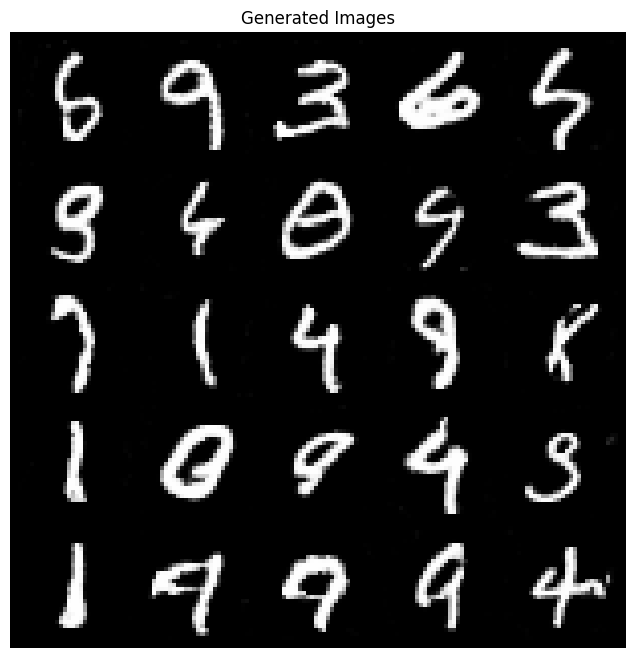

In [35]:
evaluate_gan(generator, real_imgs)

This shows that the model has indeed learned to generate diverse samples of good quality.

### Question 2(d)

In [36]:
# VAE Model
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 400),
            nn.ReLU(),
            nn.Linear(400, 40)  
        )
        self.decoder = nn.Sequential(
            nn.Linear(20, 400),
            nn.ReLU(),
            nn.Linear(400, 28*28),
            nn.Sigmoid()
        )
        self.latent_dim = latent_dim

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.encoder(x)
        mu, logvar = h[:, :self.latent_dim], h[:, self.latent_dim:]
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

# Train VAE
vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=0.001)
criterion = nn.BCELoss(reduction='sum')

# Load MNIST
transform = transforms.Compose([transforms.ToTensor()])
mnist_data = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
mnist_loader = torch.utils.data.DataLoader(mnist_data, batch_size=128, shuffle=True)

for epoch in range(10):
    for images, _ in mnist_loader:
        images = images.to(device).view(-1, 28*28)
        recon, mu, logvar = vae(images)
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = criterion(recon, images) + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Generate VAE Samples
vae.eval()
z = torch.randn(25, 20).to(device)
vae_images = vae.decoder(z).view(-1, 1, 28, 28).detach().to(device)

In [37]:
# Define DDPM Model
model = Unet(dim=28, channels=1, dim_mults=(1, 2, 4)).to(device)
diffusion = GaussianDiffusion(model, image_size=28, timesteps=1000).to(device)

# Load MNIST
mnist_data = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
mnist_loader = torch.utils.data.DataLoader(mnist_data, batch_size=64, shuffle=True)

# Train DDPM
optimizer = optim.Adam(model.parameters(), lr=0.0001)
for epoch in range(10):
    for images, _ in mnist_loader:
        images = images.to(device)
        loss = diffusion(images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Generate DDPM Samples
model.eval()
ddpm_images = diffusion.sample(batch_size=25).detach().to(device)

sampling loop time step: 100%|██████████████| 1000/1000 [02:45<00:00,  6.05it/s]


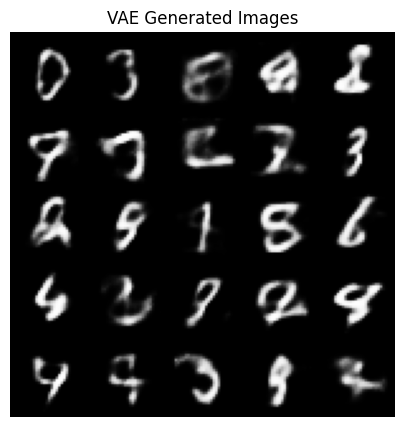

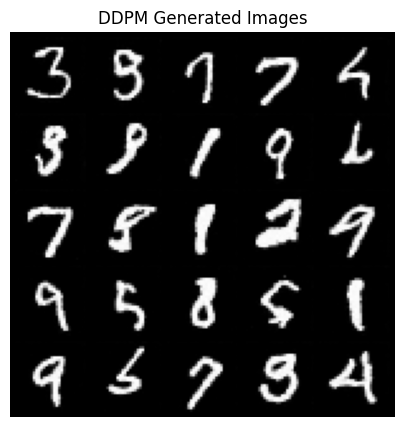

In [38]:
def plot_images(images, title):
    grid = make_grid(images, nrow=5, normalize=True)
    plt.figure(figsize=(5, 5))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title(title)
    plt.axis('off')
    plt.show()

plot_images(vae_images, "VAE Generated Images")
plot_images(ddpm_images, "DDPM Generated Images")

In [39]:
def calculate_inception_score(fake_images, inception_model, splits=10):
    fake_images = F.interpolate(fake_images, size=(299, 299), mode='bilinear', align_corners=False)
    fake_images = fake_images.repeat(1, 3, 1, 1)  # Convert grayscale to 3 channels
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inception_model = inception_model.to(device)

    fake_images = fake_images.to(device)
    preds = inception_model(fake_images).softmax(dim=1)
    split_scores = []
    for i in range(splits):
        part = preds[i * (len(preds) // splits): (i+1) * (len(preds) // splits)]
        kl_div = part * (torch.log(part) - torch.log(part.mean(dim=0, keepdim=True)))
        split_scores.append(torch.exp(kl_div.sum(dim=1).mean()))
    return torch.mean(torch.tensor(split_scores)), torch.std(torch.tensor(split_scores))

# Load Pretrained Inception Model

inception_model = inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1, transform_input=False).to(device)
inception_model.fc = torch.nn.Identity()
inception_model.eval()

# Compute Scores
vae_is, vae_std = calculate_inception_score(vae_images, inception_model)
ddpm_is, ddpm_std = calculate_inception_score(ddpm_images, inception_model)

print(f"VAE Inception Score (IS): {vae_is:.2f} ± {vae_std:.2f}")
print(f"DDPM Inception Score (IS): {ddpm_is:.2f} ± {ddpm_std:.2f}")

VAE Inception Score (IS): 1.02 ± 0.00
DDPM Inception Score (IS): 1.01 ± 0.00


In [42]:
import os
import torchvision.utils as vutils

def save_images(images, folder):
    os.makedirs(folder, exist_ok=True)
    for i, img in enumerate(images):
        vutils.save_image(img, f"{folder}/{i}.png", normalize=True)

# Save GAN, VAE, and DDPM generated images
save_images(vae_images, "vae_images")
save_images(ddpm_images, "ddpm_images")

# Save real MNIST images
save_images(real_imgs, "mnist_real")

In [43]:
real_path = "mnist_real"
vae_fid = fid_score.calculate_fid_given_paths(["vae_images", real_path], batch_size=50, device=device, dims=2048)
ddpm_fid = fid_score.calculate_fid_given_paths(["ddpm_images", real_path], batch_size=50, device=device, dims=2048)

print(f"VAE Fréchet Inception Distance (FID Score): {vae_fid:.2f}")
print(f"DDPM Fréchet Inception Distance (FID Score): {ddpm_fid:.2f}")

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /home/akshay/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████████████████████████████████| 91.2M/91.2M [00:04<00:00, 19.9MB/s]


100%|█████████████████████████████████████████████| 2/2 [00:07<00:00,  3.83s/it]


100%|█████████████████████████████████████████████| 2/2 [00:07<00:00,  3.68s/it]


VAE Fréchet Inception Distance (FID Score): 122.53
DDPM Fréchet Inception Distance (FID Score): 87.16


VAE has the worst FID score. This is because VAEs tend to generate blurry images because of the Gaussian sampling in the latent space, leading to lower quality images.
<br>
DDPMs improve over VAE. Diffusion models generate better images than VAE but in this case are not as strong as GAN. But usually, DDPMs generate higher quality images but require more training steps and careful noise-scheduling.
<br>
The FID score of GAN tells us that in this case it performed beter and gives improved image sharpness.

### Question 2(e)

In [45]:
# Hyperparameters
latent_dim = 2  # Very small latent space
num_epochs = 30
batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# Filter for digits 0 and 1
idx = (mnist.targets == 0) | (mnist.targets == 1)
mnist.data = mnist.data[idx]
mnist.targets = mnist.targets[idx]
train_loader = torch.utils.data.DataLoader(mnist, batch_size=batch_size, shuffle=True)

In [46]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (128, 7, 7)),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),  # 6272
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img)

In [47]:
# Initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

fixed_noise = torch.randn(16, latent_dim, device=device)

Epoch [1/30] | D Loss: 0.0041 | G Loss: 6.7546
Epoch [2/30] | D Loss: 0.0098 | G Loss: 6.3359
Epoch [3/30] | D Loss: 0.0105 | G Loss: 6.2284
Epoch [4/30] | D Loss: 0.0049 | G Loss: 6.7530
Epoch [5/30] | D Loss: 0.0059 | G Loss: 6.7434
Epoch [6/30] | D Loss: 0.0058 | G Loss: 7.1274
Epoch [7/30] | D Loss: 0.0036 | G Loss: 6.5300
Epoch [8/30] | D Loss: 0.0029 | G Loss: 6.7372
Epoch [9/30] | D Loss: 0.0035 | G Loss: 7.3515
Epoch [10/30] | D Loss: 0.0057 | G Loss: 6.6400


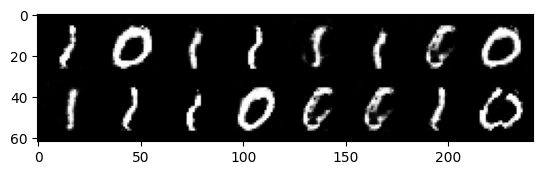

Epoch [11/30] | D Loss: 0.0022 | G Loss: 8.5757
Epoch [12/30] | D Loss: 0.0025 | G Loss: 8.4747
Epoch [13/30] | D Loss: 0.0024 | G Loss: 6.1020
Epoch [14/30] | D Loss: 0.0047 | G Loss: 6.9338
Epoch [15/30] | D Loss: 0.0056 | G Loss: 5.4537
Epoch [16/30] | D Loss: 0.0058 | G Loss: 6.6264
Epoch [17/30] | D Loss: 0.0037 | G Loss: 8.2392
Epoch [18/30] | D Loss: 0.0134 | G Loss: 7.6995
Epoch [19/30] | D Loss: 0.0070 | G Loss: 6.2547
Epoch [20/30] | D Loss: 0.0064 | G Loss: 7.0419


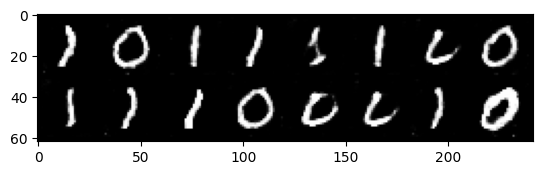

Epoch [21/30] | D Loss: 0.0042 | G Loss: 5.7451
Epoch [22/30] | D Loss: 0.0095 | G Loss: 6.4945
Epoch [23/30] | D Loss: 0.0102 | G Loss: 5.4299
Epoch [24/30] | D Loss: 0.0065 | G Loss: 7.9177
Epoch [25/30] | D Loss: 0.0123 | G Loss: 6.3612
Epoch [26/30] | D Loss: 0.0067 | G Loss: 6.7636
Epoch [27/30] | D Loss: 0.0118 | G Loss: 6.6061
Epoch [28/30] | D Loss: 0.0082 | G Loss: 6.4008
Epoch [29/30] | D Loss: 0.0129 | G Loss: 5.8362
Epoch [30/30] | D Loss: 0.0064 | G Loss: 5.6214


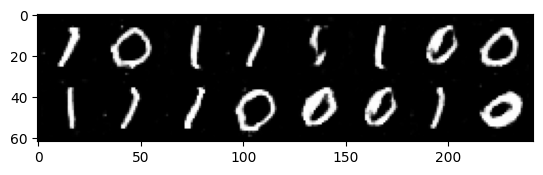

In [48]:
# Training loop with over-trained discriminator
for epoch in range(num_epochs):
    for i, (real_imgs, _) in enumerate(train_loader):
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        for _ in range(10):  
            optimizer_D.zero_grad()

            # Real images
            real_outputs = discriminator(real_imgs)

            loss_real = criterion(real_outputs, real_labels)

            # Fake images
            z = torch.randn(batch_size, latent_dim, device=device)
            fake_imgs = generator(z).detach()
            fake_outputs = discriminator(fake_imgs)
            loss_fake = criterion(fake_outputs, fake_labels)

            loss_D = loss_real + loss_fake
            loss_D.backward()
            optimizer_D.step()

        optimizer_G.zero_grad()
        z = torch.randn(batch_size, latent_dim, device=device)
        fake_imgs = generator(z)
        fake_outputs = discriminator(fake_imgs)
        loss_G = criterion(fake_outputs, real_labels)

        loss_G.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] | D Loss: {loss_D.item():.4f} | G Loss: {loss_G.item():.4f}")

    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            generated_imgs = generator(fixed_noise).to(device)
        grid = make_grid(generated_imgs, normalize=True)
        plt.imshow(grid.permute(1, 2, 0))
        plt.show()

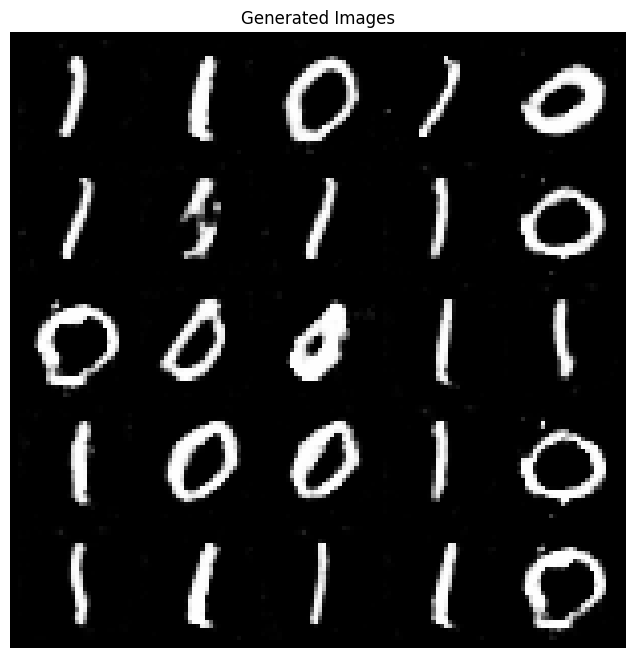

In [49]:
def generate_images(generator, num_images=25, noise_dim=2):
    generator.eval()  # Set generator to evaluation mode
    noise = torch.randn(num_images, noise_dim, device=device)
    with torch.no_grad():
        fake_images = generator(noise).to(device) # Generate fake images
    fake_images = (fake_images + 1) / 2  # Normalize to [0,1] for visualization
    return fake_images

# Function to plot generated images
def plot_generated_images(generator, num_images=25):
    fake_images = generate_images(generator, num_images)
    grid = make_grid(fake_images.to(device), nrow=5)  # Create a 5x5 grid
    plt.figure(figsize=(8,8))
    plt.imshow(grid.permute(1, 2, 0).numpy(), cmap="gray")
    plt.axis("off")
    plt.title("Generated Images")
    plt.show()

plot_generated_images(generator)

To induce Mode collapse, we did the following:
<br>
1. We reduced the generator's learning capacity. We set the latent_dim = 2 (instead of a typical value like 100). Also we simplified the generator architecture by reducing layers.
2. We over-trained the discriminator. We trained the discriminator 10 times per generator update.
3. Also we reduced the diversity in training data. For that we filtered the MNIST dataset to include only digits 0 and 1.

### Question 3

In [51]:
import clip
from torchvision import datasets, transforms
from PIL import Image

# Load CLIP model
model, preprocess = clip.load("ViT-B/32", device=device)
model.eval()  

# Define MNIST test dataset
mnist_test = datasets.MNIST(root="./data", train=False, download=True)

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  
])

In [52]:
# Create text descriptions for each digit
class_descriptions = [f"A photo of the handwritten digit {i}." for i in range(10)]

# Tokenize the text using CLIP
text_tokens = clip.tokenize(class_descriptions).to(device)

In [53]:
# Encode text descriptions to obtain embeddings
with torch.no_grad():
    text_embeddings = model.encode_text(text_tokens)
    text_embeddings /= text_embeddings.norm(dim=-1, keepdim=True) 

In [54]:
correct = 0
total = 0

for i in range(len(mnist_test)):
    image, label = mnist_test[i]  
    image = transform(image).unsqueeze(0).to(device) 

    with torch.no_grad():
        image_embedding = model.encode_image(image)
        image_embedding /= image_embedding.norm(dim=-1, keepdim=True)  

        similarities = (image_embedding @ text_embeddings.T).squeeze(0)  
        predicted_label = similarities.argmax().item()  

    if predicted_label == label:
        correct += 1
    total += 1

    if i % 1000 == 0:  
        print(f"Processed {i}/{len(mnist_test)} images...")

# Compute accuracy
accuracy = correct / total
print(f"Zero-Shot Accuracy on MNIST: {accuracy:.4f}")

Processed 0/10000 images...
Processed 1000/10000 images...
Processed 2000/10000 images...
Processed 3000/10000 images...
Processed 4000/10000 images...
Processed 5000/10000 images...
Processed 6000/10000 images...
Processed 7000/10000 images...
Processed 8000/10000 images...
Processed 9000/10000 images...
Zero-Shot Accuracy on MNIST: 0.2759


The accuracy of the CLIP model is around 28%. It means that the accuracy is above random. This value of accuracy is because:
<br>
1. CLIP was trained on real-world images, not handwritten digits.
2. Handwritten numbers have simplistic structures that might not align with CLIP's learned representations.

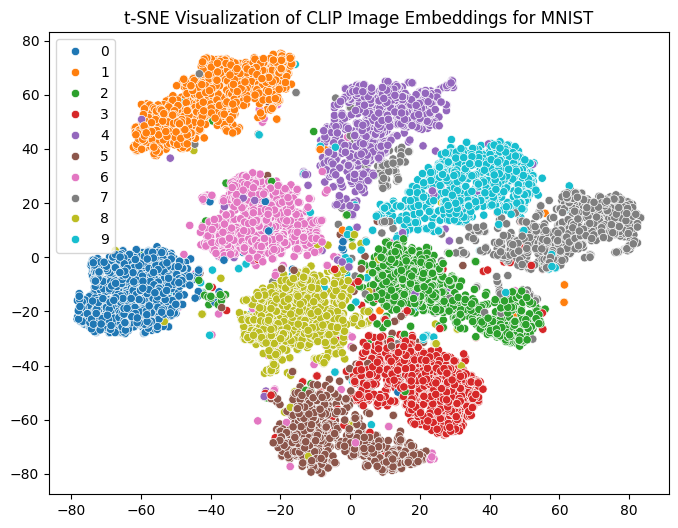

In [55]:
# Collect embeddings
image_embeddings_list = []
labels_list = []

for image, label in mnist_test:
    image = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        image_embedding = model.encode_image(image).to(device).numpy().flatten()
    image_embeddings_list.append(image_embedding)
    labels_list.append(label)

image_embeddings_np = np.array(image_embeddings_list)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(image_embeddings_np)

# Plot t-SNE results
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=labels_list, palette="tab10", legend="full")
plt.title("t-SNE Visualization of CLIP Image Embeddings for MNIST")
plt.show()